# **Artificial Neural Networks and Deep Learning**

---

## **Lecture 7: Advancements in Convolutional Block Design**

<img src="https://drive.google.com/uc?export=view&id=1Ruszte0iwJ-i5VgTCApvJXz7yXWgnZzi" width="500"/>

## ⚙️ Import libraries

In [23]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
!pip install torchview
from torchview import draw_graph

torch.manual_seed(SEED)
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.9.0+cu126
Device: cpu


In [24]:
# Define input and output dimensions
input_shape = (3, 64, 64)
output_shape = 10

# Define the batch size
BATCH_SIZE = 128

# Initialize configuration for convolutional layers
stack = 2
blocks = 2
filters = 32
kernel_size = 3


print(f"Input shape: {input_shape}")
print(f"Output shape: {output_shape}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Stack: {stack}")
print(f"Blocks: {blocks}")
print(f"Filters: {filters}")
print(f"Kernel size: {kernel_size}")

Input shape: (3, 64, 64)
Output shape: 10
Batch size: 128
Stack: 2
Blocks: 2
Filters: 32
Kernel size: 3


## 🛠️ **First Convolutional Neural Network Block (AlexNet, 2012)**

<img src="https://miro.medium.com/v2/resize:fit:1400/1*bD_DMBtKwveuzIkQTwjKQQ.png" width="800"/>

---
**Key Features and Achievements**


*   First successful deep CNN for ImageNet
*   Introduced ReLU to combat vanishing gradient

**Key building block:**

*   Conv -> ReLU -> MaxPool sequence
*   Multiple layers stacked sequentially

**Impact:**

*   Started the "deep learning revolution"
*   Established basic CNN design patterns

**📜 Paper:** ["ImageNet Classification with Deep Convolutional Neural Networks", Krizhevsky et al.](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)



In [25]:
class BasicCNNBlock(nn.Module):
    """A foundational CNN block: Convolutional layer -> ReLU activation -> Max Pooling.

    This block is typical in early CNN architectures like AlexNet, combining feature extraction,
    non-linear activation, and dimensionality reduction.
    """

    def __init__(self, in_channels, filters, kernel_size=3, stack=2):
        """Initialises the BasicCNNBlock.

        Args:
            in_channels (int): Number of input channels.
            filters (int): Number of output filters (channels) for each convolutional layer.
            kernel_size (int, optional): Size of the convolutional kernel. Defaults to 3.
            stack (int, optional): Number of Conv-ReLU layers before pooling. Defaults to 2.
        """
        super().__init__()

        layers_list = []
        current_channels = in_channels

        #block: some convolution, some activation, some pooling

        # Stack Conv-ReLU layers, preserving spatial dimensions with 'padding=same'.
        for i in range(stack):
            layers_list.append(
                nn.Conv2d(current_channels, filters, kernel_size, padding='same', bias=False) # Bias is often omitted before BatchNorm.
            )
            layers_list.append(nn.ReLU()) # Apply non-linearity.
            current_channels = filters # Update channels for the next layer.

        # MaxPool to halve spatial dimensions and provide translation robustness.
        layers_list.append(nn.MaxPool2d(2))

        self.block = nn.Sequential(*layers_list)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after block processing.
        """
        return self.block(x)


class BasicCNNModel(nn.Module):
    """A complete CNN model constructed from multiple BasicCNNBlocks.

    This model exemplifies a basic CNN architecture, stacking convolutional blocks,
    followed by flattening and a final dense layer for classification.
    """

    def __init__(self, input_shape, output_shape, filters=64, kernel_size=3, stack=2, blocks=3):
        """Initialises the BasicCNNModel.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 64.
            kernel_size (int, optional): Kernel size for convolutional layers. Defaults to 3.
            stack (int, optional): Number of Conv-ReLU layers per block. Defaults to 2.
            blocks (int, optional): Number of `BasicCNNBlock` instances to stack. Defaults to 3.
        """
        super().__init__()

        block_list = []
        current_channels = input_shape[0] # Input channels (e.g., 3 for RGB).
        current_filters = filters # Starting filters.

        # Create stacked blocks, typically doubling filters for each subsequent block.
        for b in range(blocks):
            block_list.append(BasicCNNBlock(
                in_channels=current_channels,
                filters=current_filters,
                kernel_size=kernel_size,
                stack=stack
            ))
            current_channels = current_filters # Output channels become input for the next block.
            current_filters *= 2 # Double filters for the next block.

        self.blocks = nn.Sequential(*block_list)

        # Dynamically calculate the flattened size for the linear layer.
        # A dummy tensor is used to determine the feature map size post-convolution.
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            dummy_out = self.blocks(dummy)
            flatten_size = dummy_out.view(1, -1).shape[1]

        self.flatten = nn.Flatten() # Flatten multi-dimensional output to 1D vector.
        self.dense = nn.Linear(flatten_size, output_shape) # Final fully connected layer.

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        x = self.blocks(x)
        x = self.flatten(x)
        x = self.dense(x)
        return F.softmax(x, dim=1) # Convert logits to probabilities.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           9,216
              ReLU-4           [-1, 32, 64, 64]               0
         MaxPool2d-5           [-1, 32, 32, 32]               0
     BasicCNNBlock-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,432
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
        MaxPool2d-11           [-1, 64, 16, 16]               0
    BasicCNNBlock-12           [-1, 64, 16, 16]               0
          Flatten-13                [-1, 16384]               0
           Linear-14                   

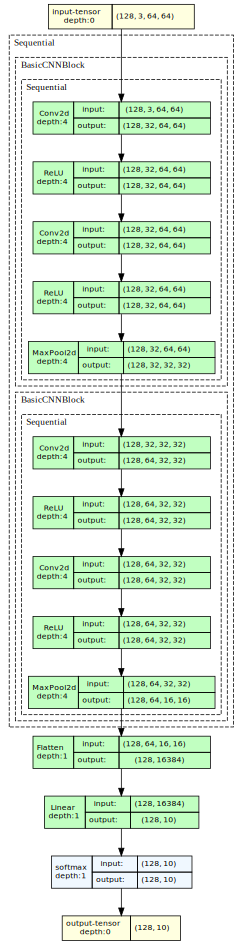

In [26]:
# Create and display the Basic CNN model
basic_cnn = BasicCNNModel(input_shape, output_shape, filters, kernel_size, stack, blocks).to(device)
summary(basic_cnn, input_size=input_shape)
model_graph = draw_graph(basic_cnn, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=5)
model_graph.visual_graph

## 🛠️ **Global Average Pooling (NiN, 2013)**

<img src="https://www.researchgate.net/publication/363231491/figure/fig5/AS:11431281179419529@1691187457237/Illustration-of-global-average-pooling-GAP.png" width="800"/>

---
**Key Features and Achievements**


*   Replaced Flatten and Dense layers
*   Enforced correspondence between feature maps and categories

**Key building block:**

*   Global spatial average of each feature map
*   Direct feature-to-category mapping

**Impact:**

*   Dramatic parameter reduction
*   Better generalization with fewer parameters

**📜 Paper:** ["Network In Network", Lin et al.](https://arxiv.org/pdf/1312.4400)



In [27]:
class GAPModel(nn.Module):
    """Model using Global Average Pooling (GAP) instead of Flatten + Dense.

    This architecture replaces the traditional flattening and fully-connected layers
    with Global Average Pooling, which reduces parameters and often improves generalisation.
    """

    def __init__(self, input_shape, output_shape, filters=32, kernel_size=3,
                 stack=2, blocks=3):
        """Initialises the GAPModel.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 32.
            kernel_size (int, optional): Kernel size for convolutional layers. Defaults to 3.
            stack (int, optional): Number of Conv-ReLU layers per block. Defaults to 2.
            blocks (int, optional): Number of `BasicCNNBlock` instances to stack. Defaults to 3.
        """
        super().__init__()

        self.blocks_list = nn.ModuleList()
        current_channels = input_shape[0]
        current_filters = filters

        # Create multiple BasicCNNBlocks, doubling filters for each subsequent block.
        for b in range(blocks):
            block = BasicCNNBlock(
                in_channels=current_channels,
                filters=current_filters,
                kernel_size=kernel_size,
                stack=stack
            )
            self.blocks_list.append(block)
            current_channels = current_filters
            current_filters *= 2

        # Global Average Pooling replaces Flatten + Dense for parameter reduction.
        self.gap = nn.AdaptiveAvgPool2d(1) # Pools each feature map to a single value.
        self.flatten = nn.Flatten() # Flattens the pooled output.
        self.dense = nn.Linear(current_channels, output_shape) # Final classification layer.

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        for block in self.blocks_list:
            x = block(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense(x)
        return F.softmax(x, dim=1) # Converts logits to probabilities.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           9,216
              ReLU-4           [-1, 32, 64, 64]               0
         MaxPool2d-5           [-1, 32, 32, 32]               0
     BasicCNNBlock-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,432
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
        MaxPool2d-11           [-1, 64, 16, 16]               0
    BasicCNNBlock-12           [-1, 64, 16, 16]               0
AdaptiveAvgPool2d-13             [-1, 64, 1, 1]               0
          Flatten-14                   

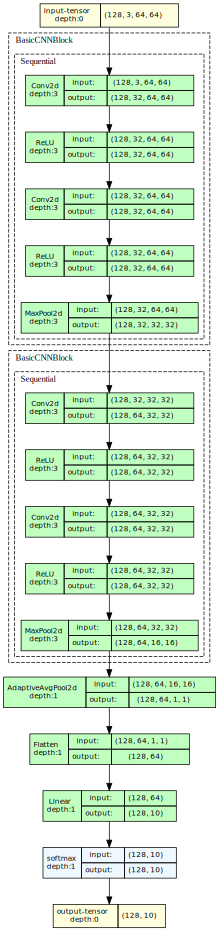

In [28]:
# Create and display the GAP model
gap_model = GAPModel(input_shape, output_shape, filters, kernel_size, stack, blocks).to(device)
summary(gap_model, input_size=input_shape)
model_graph = draw_graph(gap_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True)
model_graph.visual_graph

## 🛠️ **Inception Block (GoogLeNet, 2014)**

<img src="https://ar5iv.labs.arxiv.org/html/1707.07128/assets/googlenetInception.png" width="800"/>


---
**Key Features and Achievements**


*   Multi-scale feature processing
*   Winner of ILSVRC 2014

**Key building block:**

*   Parallel paths with different kernels
*   1x1 bottleneck for efficiency
*   Feature concatenation

**Impact:**

*   Established multi-path processing
*   Introduced 1x1 bottleneck concept

**📜 Paper:** ["Going deeper with convolutions", Szegedy et al.](https://arxiv.org/pdf/1409.4842)

In [29]:
class InceptionModule(nn.Module):
    """Single Inception module with parallel convolution paths.

    This module processes input through 1x1, 3x3, 5x5 convolutions and a max-pooling branch,
    concatenating their outputs to capture multi-scale features.
    """

    def __init__(self, in_channels, filters):
        """Initialises the InceptionModule.

        Args:
            in_channels (int): Number of input channels.
            filters (int): Base number of filters for the module's output, divided among branches.
        """
        super().__init__()

        # 1x1 convolution path
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, filters // 4, 1, padding='same'),
            nn.ReLU()
        )

        # 3x3 convolution path with 1x1 reduction (bottleneck)
        self.conv3_reduce = nn.Sequential(
            nn.Conv2d(in_channels, filters // 8, 1, padding='same'),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(filters // 8, filters // 4, 3, padding='same'),
            nn.ReLU()
        )

        # 5x5 convolution path with 1x1 reduction (bottleneck)
        self.conv5_reduce = nn.Sequential(
            nn.Conv2d(in_channels, filters // 12, 1, padding='same'),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(filters // 12, filters // 4, 5, padding='same'),
            nn.ReLU()
        )

        # Max pooling path with 1x1 projection
        self.pool = nn.MaxPool2d(3, stride=1, padding=1) # MaxPool maintains spatial dimensions here due to padding.
        self.pool_proj = nn.Sequential(
            nn.Conv2d(in_channels, filters // 4, 1, padding='same'),
            nn.ReLU()
        )

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after parallel processing and concatenation.
        """
        conv1 = self.conv1(x)
        conv3 = self.conv3(self.conv3_reduce(x))
        conv5 = self.conv5(self.conv5_reduce(x))
        pool_proj = self.pool_proj(self.pool(x))
        # Concatenate outputs along the channel dimension.
        return torch.cat([conv1, conv3, conv5, pool_proj], dim=1)


class InceptionBlock(nn.Module):
    """An Inception block consisting of stacked InceptionModules followed by MaxPooling.

    This block typically reduces spatial dimensions at its end.
    """

    def __init__(self, in_channels, filters, stack=2):
        """Initialises the InceptionBlock.

        Args:
            in_channels (int): Number of input channels.
            filters (int): Base filters for the InceptionModules.
            stack (int, optional): Number of InceptionModule instances to stack. Defaults to 2.
        """
        super().__init__()

        self.inception_modules = nn.ModuleList()
        current_channels = in_channels

        # Stack multiple InceptionModules.
        for s in range(stack):
            self.inception_modules.append(InceptionModule(current_channels, filters))
            current_channels = filters  # Output channels after concatenation within InceptionModule.

        # MaxPooling at the end of the block to halve spatial dimensions.
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after Inception modules and pooling.
        """
        for module in self.inception_modules:
            x = module(x)
        x = self.pool(x)
        return x


class InceptionModel(nn.Module):
    """Complete CNN model using multiple InceptionBlocks and Global Average Pooling.

    This model exemplifies an Inception-style architecture, suitable for classification tasks.
    """

    def __init__(self, input_shape, output_shape, filters=32, stack=2, blocks=3):
        """Initialises the InceptionModel.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 32.
            stack (int, optional): Number of InceptionModule instances per block. Defaults to 2.
            blocks (int, optional): Number of `InceptionBlock` instances to stack. Defaults to 3.
        """
        super().__init__()

        self.blocks_list = nn.ModuleList()
        current_channels = input_shape[0]
        current_filters = filters

        # Stack multiple InceptionBlocks, typically doubling filters for each.
        for b in range(blocks):
            self.blocks_list.append(
                InceptionBlock(current_channels, current_filters, stack)
            )
            current_channels = current_filters
            current_filters *= 2

        # Calculate final filters for the linear layer.
        final_filters = filters * (2 ** (blocks - 1))

        # Global Average Pooling, Flatten, and Dense layer for classification.
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(final_filters, output_shape)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        for block in self.blocks_list:
            x = block(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense(x)
        return F.softmax(x, dim=1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]              32
              ReLU-2            [-1, 8, 64, 64]               0
            Conv2d-3            [-1, 4, 64, 64]              16
              ReLU-4            [-1, 4, 64, 64]               0
            Conv2d-5            [-1, 8, 64, 64]             296
              ReLU-6            [-1, 8, 64, 64]               0
            Conv2d-7            [-1, 2, 64, 64]               8
              ReLU-8            [-1, 2, 64, 64]               0
            Conv2d-9            [-1, 8, 64, 64]             408
             ReLU-10            [-1, 8, 64, 64]               0
        MaxPool2d-11            [-1, 3, 64, 64]               0
           Conv2d-12            [-1, 8, 64, 64]              32
             ReLU-13            [-1, 8, 64, 64]               0
  InceptionModule-14           [-1, 32,

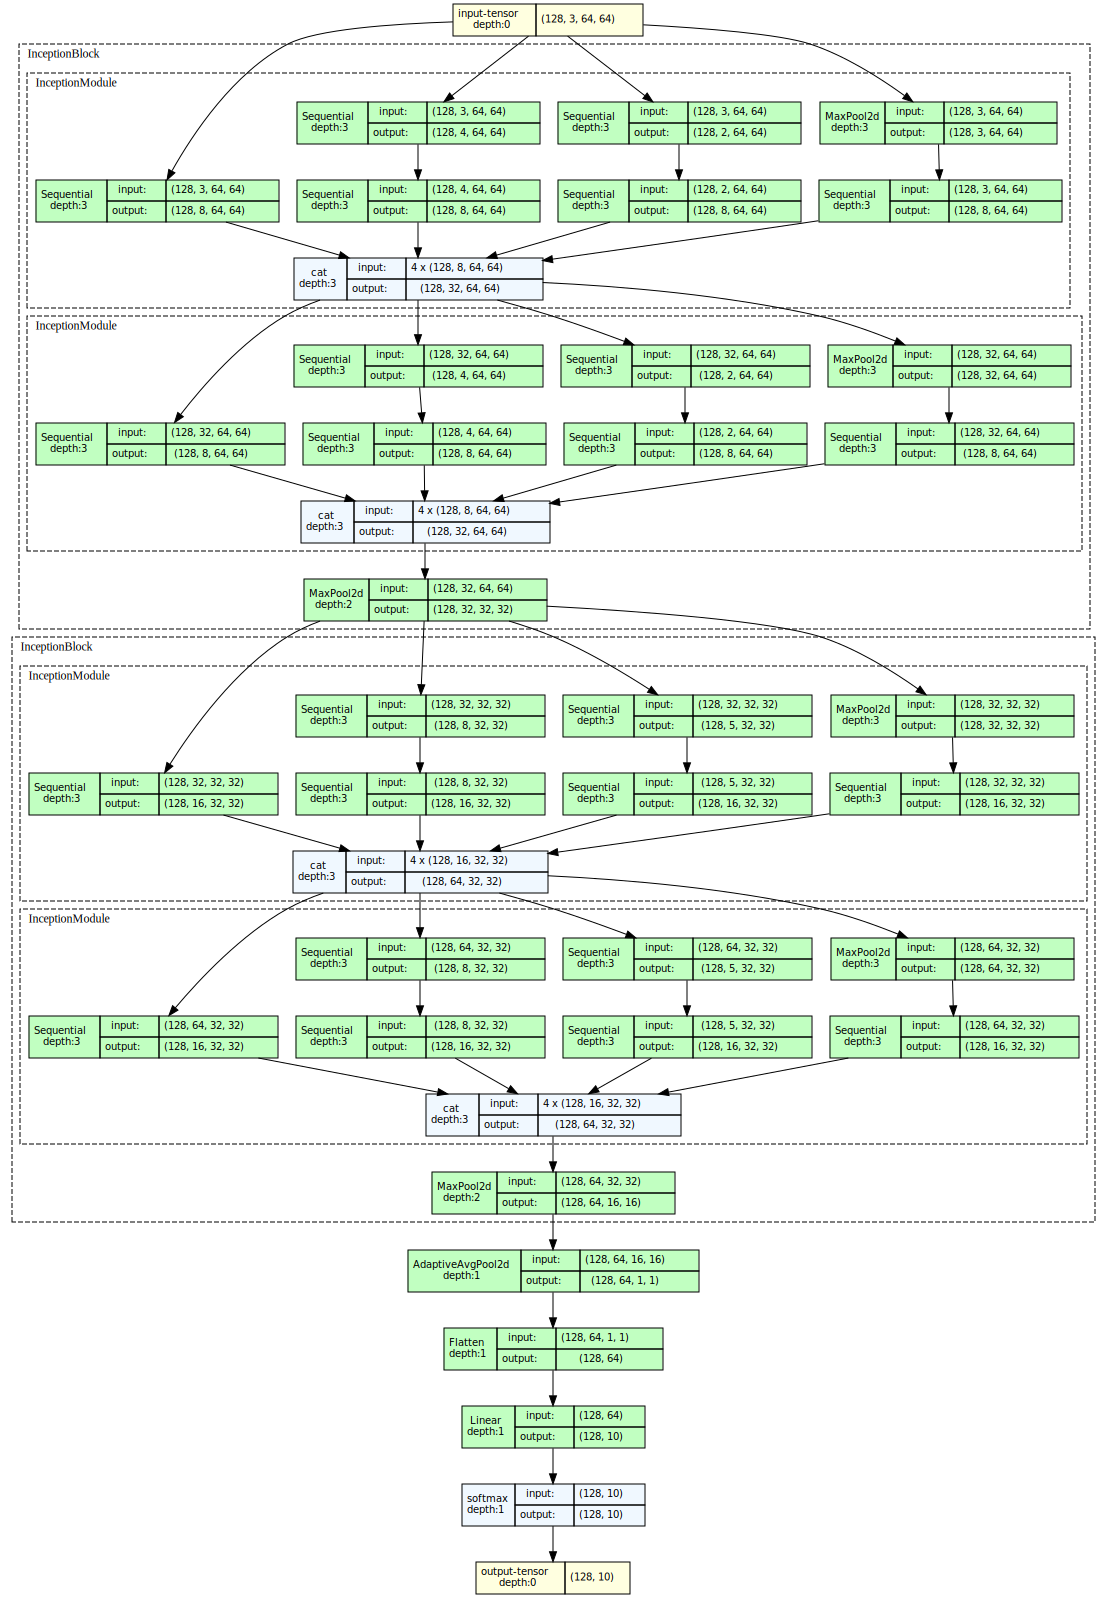

In [30]:
# Create and display the Inception model
inception_model = InceptionModel(input_shape, output_shape, filters, stack, blocks).to(device)
summary(inception_model, input_size=input_shape)
model_graph = draw_graph(inception_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True)
model_graph.visual_graph

## 🛠️ **Batch Normalization (Inception Block with BN, 2015)**

<img src="https://miro.medium.com/v2/resize:fit:898/0*pSSzicm1IH4hXOHc.png" width="800"/>


---
**Key Features and Achievements**


*   Normalized activations in each layer
*   Reduced internal covariate shift

**Key building block:**

*   Normalize: $\hat{x} = \frac{x-\mu_B}{\sqrt{\sigma^2_B+\epsilon}}$
*   Scale and shift: $y = \gamma\hat{x} + \beta$
*   Placed before activation

**Impact:**

*   Enabled much faster training
*   Reduced sensitivity to initialization
*   Became standard in modern networks

**📜 Paper:** ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", Ioffe and Szegedy](https://arxiv.org/pdf/1502.03167)

In [31]:
class InceptionBlockBN(nn.Module):
    """Inception Block with Batch Normalisation.

    Stacks Inception Modules, maintaining spatial dimensions, followed by MaxPool2d.
    """
    def __init__(self, in_channels, filters, stack=2):
        """Initialises the InceptionBlockBN.

        Args:
            in_channels (int): Number of input channels.
            filters (int): Base number of filters for the module's output.
            stack (int, optional): Number of Inception Module instances to stack. Defaults to 2.
        """
        super().__init__()

        self.inception_modules = nn.ModuleList()
        current_channels = in_channels

        for s in range(stack):
            module = nn.ModuleDict({ #assign name to layers
                # 1x1 path
                'conv1': nn.Sequential(
                    nn.Conv2d(current_channels, filters // 4, 1, padding='same', bias=False),
                    nn.BatchNorm2d(filters // 4),
                    nn.ReLU()
                ),
                # 3x3 path
                'conv3': nn.Sequential(
                    nn.Conv2d(current_channels, filters // 8, 1, padding='same', bias=False),
                    nn.BatchNorm2d(filters // 8),
                    nn.ReLU(),
                    nn.Conv2d(filters // 8, filters // 4, 3, padding='same', bias=False),
                    nn.BatchNorm2d(filters // 4),
                    nn.ReLU()
                ),
                # 5x5 path
                'conv5': nn.Sequential(
                    nn.Conv2d(current_channels, filters // 12, 1, padding='same', bias=False),
                    nn.BatchNorm2d(filters // 12),
                    nn.ReLU(),
                    nn.Conv2d(filters // 12, filters // 4, 5, padding='same', bias=False),
                    nn.BatchNorm2d(filters // 4),
                    nn.ReLU()
                ),
                # Pool path
                'pool': nn.Sequential(
                    nn.MaxPool2d(3, stride=1, padding=1),
                    nn.Conv2d(current_channels, filters // 4, 1, padding='same', bias=False),
                    nn.BatchNorm2d(filters // 4),
                    nn.ReLU()
                )
            })
            self.inception_modules.append(module)
            current_channels = (filters // 4) * 4 # Output channels after concatenation

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after block processing.
        """
        for module in self.inception_modules:
            conv1 = module['conv1'](x)
            conv3 = module['conv3'](x)
            conv5 = module['conv5'](x)
            pool = module['pool'](x)
            x = torch.cat([conv1, conv3, conv5, pool], dim=1)

        x = self.pool(x)
        return x

class InceptionBNModel(nn.Module):
    """Complete CNN model using multiple InceptionBlockBN instances and Global Average Pooling.

    Suitable for classification tasks, integrating Batch Normalisation within Inception-style blocks.
    """
    def __init__(self, input_shape, output_shape, filters=32, stack=2, blocks=3):
        """Initialises the InceptionBNModel.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 32.
            stack (int, optional): Number of Inception Module instances per block. Defaults to 2.
            blocks (int, optional): Number of `InceptionBlockBN` instances to stack. Defaults to 3.
        """
        super().__init__()

        self.blocks_list = nn.ModuleList()
        current_channels = input_shape[0]
        current_filters = filters

        for b in range(blocks):
            self.blocks_list.append(
                InceptionBlockBN(current_channels, current_filters, stack=stack)
            )
            current_channels = (current_filters // 4) * 4 # Update channels for next block
            current_filters *= 2

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(current_channels, output_shape)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        for block in self.blocks_list:
            x = block(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense(x)
        return F.softmax(x, dim=1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]              24
       BatchNorm2d-2            [-1, 8, 64, 64]              16
              ReLU-3            [-1, 8, 64, 64]               0
            Conv2d-4            [-1, 4, 64, 64]              12
       BatchNorm2d-5            [-1, 4, 64, 64]               8
              ReLU-6            [-1, 4, 64, 64]               0
            Conv2d-7            [-1, 8, 64, 64]             288
       BatchNorm2d-8            [-1, 8, 64, 64]              16
              ReLU-9            [-1, 8, 64, 64]               0
           Conv2d-10            [-1, 2, 64, 64]               6
      BatchNorm2d-11            [-1, 2, 64, 64]               4
             ReLU-12            [-1, 2, 64, 64]               0
           Conv2d-13            [-1, 8, 64, 64]             400
      BatchNorm2d-14            [-1, 8,

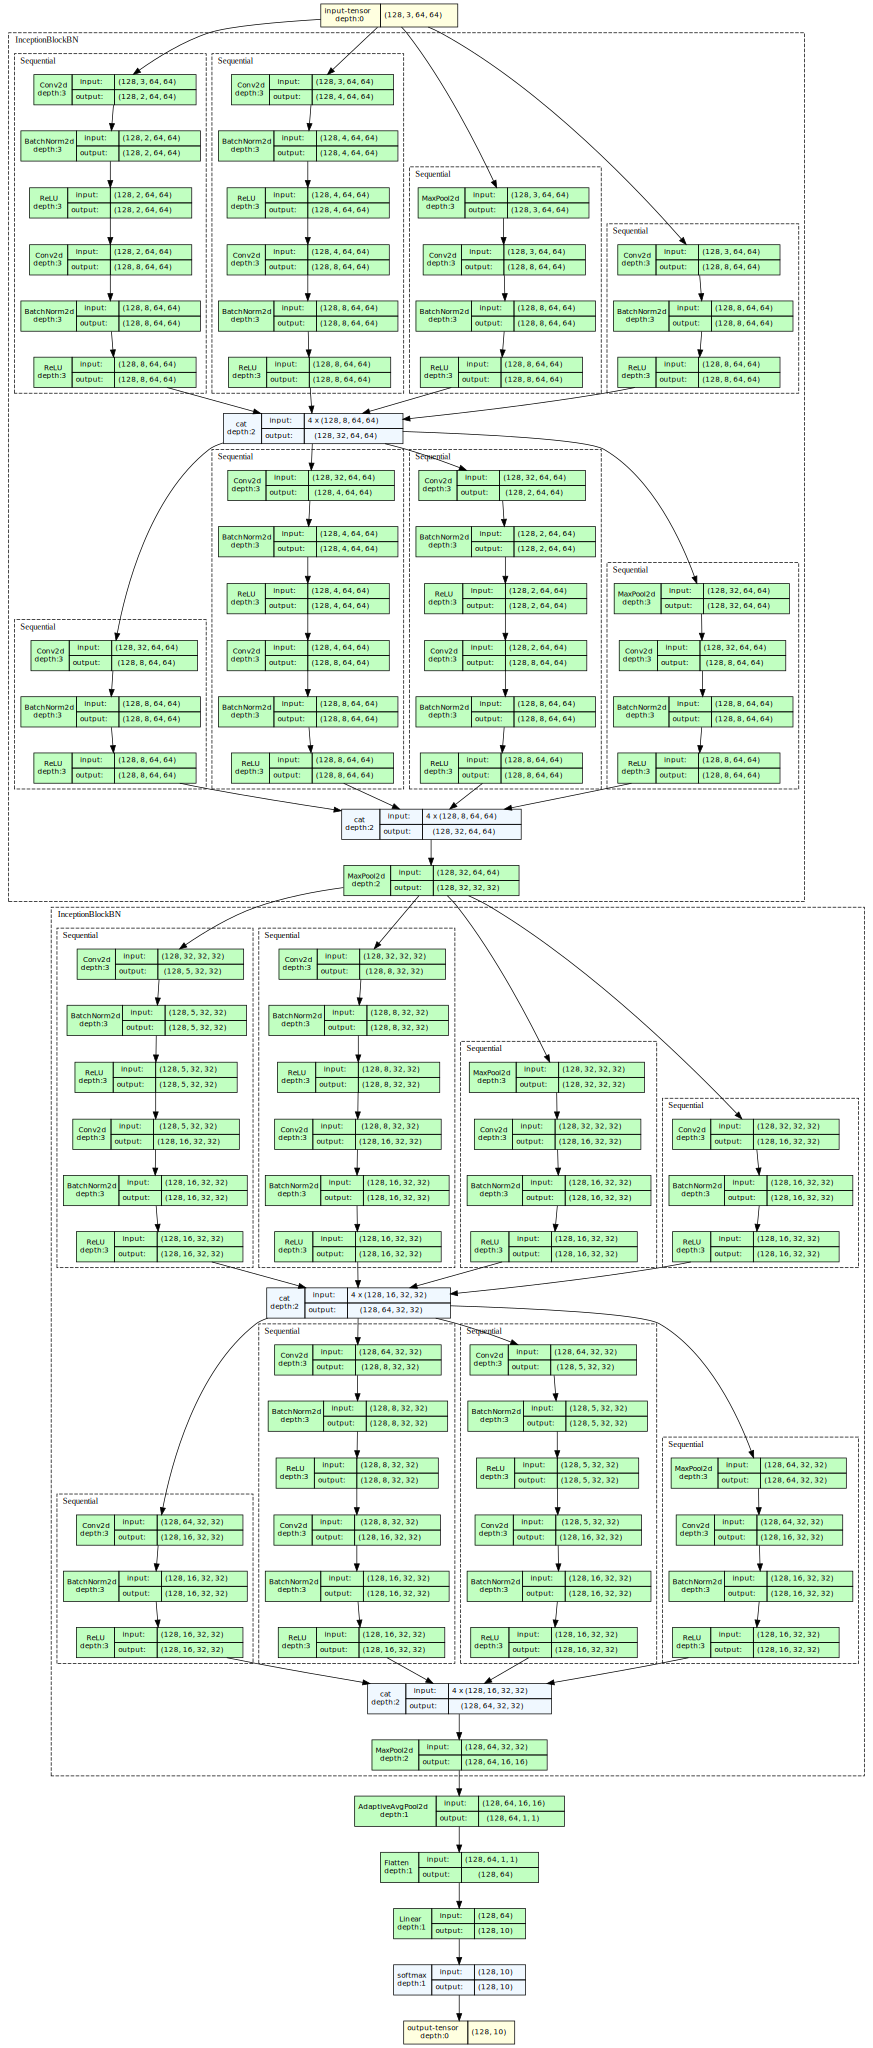

In [32]:
# Create and display the Inception with BN model
inception_bn_model = InceptionBNModel(input_shape, output_shape, filters, stack, blocks).to(device)
summary(inception_bn_model, input_size=input_shape)
model_graph = draw_graph(inception_bn_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True)
model_graph.visual_graph

## 🛠️ **Residual Block (ResNet, 2015)**

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/ResBlock.png" width="800"/>


---
**Key Features and Achievements**


*   Enabled 1000+ layer networks
*   Winner of ILSVRC 2015

**Key building block:**

*   Skip connection: F(x) + x
*   Two conv layers with BN and ReLU

**Impact:**

*   Solved deep network degradation
*   Revolutionized network design

**📜 Paper:** ["Deep Residual Learning for Image Recognition", He et al.](https://arxiv.org/pdf/1512.03385)

In [33]:
class ResidualBlock(nn.Module):
    """Standard Residual Block with stackable units + Final Pooling.
    """
    def __init__(self, in_channels, filters, kernel_size=3, stack=2):
        """Initialises the ResidualBlock.

        Args:
            in_channels (int): Number of input channels.
            filters (int): Number of output filters.
            kernel_size (int, optional): Size of the convolutional kernel. Defaults to 3.
            stack (int, optional): Number of residual units to stack. Defaults to 2.
        """
        super().__init__()

        self.units = nn.ModuleList()
        current_in = in_channels

        for s in range(stack):
            layers = nn.ModuleDict()

            # Standard ResNet Unit: Conv -> BN -> ReLU -> Conv -> BN -> Add -> ReLU
            layers['conv1'] = nn.Conv2d(current_in, filters, kernel_size, padding='same', bias=False)
            layers['bn1'] = nn.BatchNorm2d(filters)
            layers['conv2'] = nn.Conv2d(filters, filters, kernel_size, padding='same', bias=False)
            layers['bn2'] = nn.BatchNorm2d(filters)

            # Skip connection projection if dimensions mismatch
            if current_in != filters:
                layers['proj'] = nn.Sequential(
                    nn.Conv2d(current_in, filters, 1, padding='same', bias=False),
                    nn.BatchNorm2d(filters)
                )

            self.units.append(layers)
            current_in = filters # After first stack, input matches filters

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after block processing.
        """
        for unit in self.units:
            residual = x

            out = unit['conv1'](x)
            out = unit['bn1'](out)
            out = F.relu(out)

            out = unit['conv2'](out)
            out = unit['bn2'](out)

            if 'proj' in unit:
                residual = unit['proj'](residual)

            out += residual
            x = F.relu(out)

        return self.pool(x)

class ResNetModel(nn.Module):
    """Complete CNN model using multiple ResidualBlocks and Global Average Pooling.

    Suitable for classification tasks with deep architectures.
    """
    def __init__(self, input_shape, output_shape, filters=32, kernel_size=3, stack=2, blocks=3):
        """Initialises the ResNetModel.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 32.
            kernel_size (int, optional): Kernel size for convolutional layers. Defaults to 3.
            stack (int, optional): Number of residual units per block. Defaults to 2.
            blocks (int, optional): Number of `ResidualBlock` instances to stack. Defaults to 3.
        """
        super().__init__()

        self.blocks_list = nn.ModuleList()
        current_channels = input_shape[0]
        current_filters = filters

        # Stack ResidualBlocks, typically doubling filters for each.
        for b in range(blocks):
            self.blocks_list.append(
                ResidualBlock(current_channels, current_filters, kernel_size, stack)
            )
            current_channels = current_filters
            current_filters *= 2

        # Global Average Pooling, Flatten, and Dense layer for classification.
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(current_channels, output_shape)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        for block in self.blocks_list:
            x = block(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense(x)
        return F.softmax(x, dim=1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
            Conv2d-3           [-1, 32, 64, 64]           9,216
       BatchNorm2d-4           [-1, 32, 64, 64]              64
            Conv2d-5           [-1, 32, 64, 64]              96
       BatchNorm2d-6           [-1, 32, 64, 64]              64
            Conv2d-7           [-1, 32, 64, 64]           9,216
       BatchNorm2d-8           [-1, 32, 64, 64]              64
            Conv2d-9           [-1, 32, 64, 64]           9,216
      BatchNorm2d-10           [-1, 32, 64, 64]              64
        MaxPool2d-11           [-1, 32, 32, 32]               0
    ResidualBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          18,432
      BatchNorm2d-14           [-1, 64,

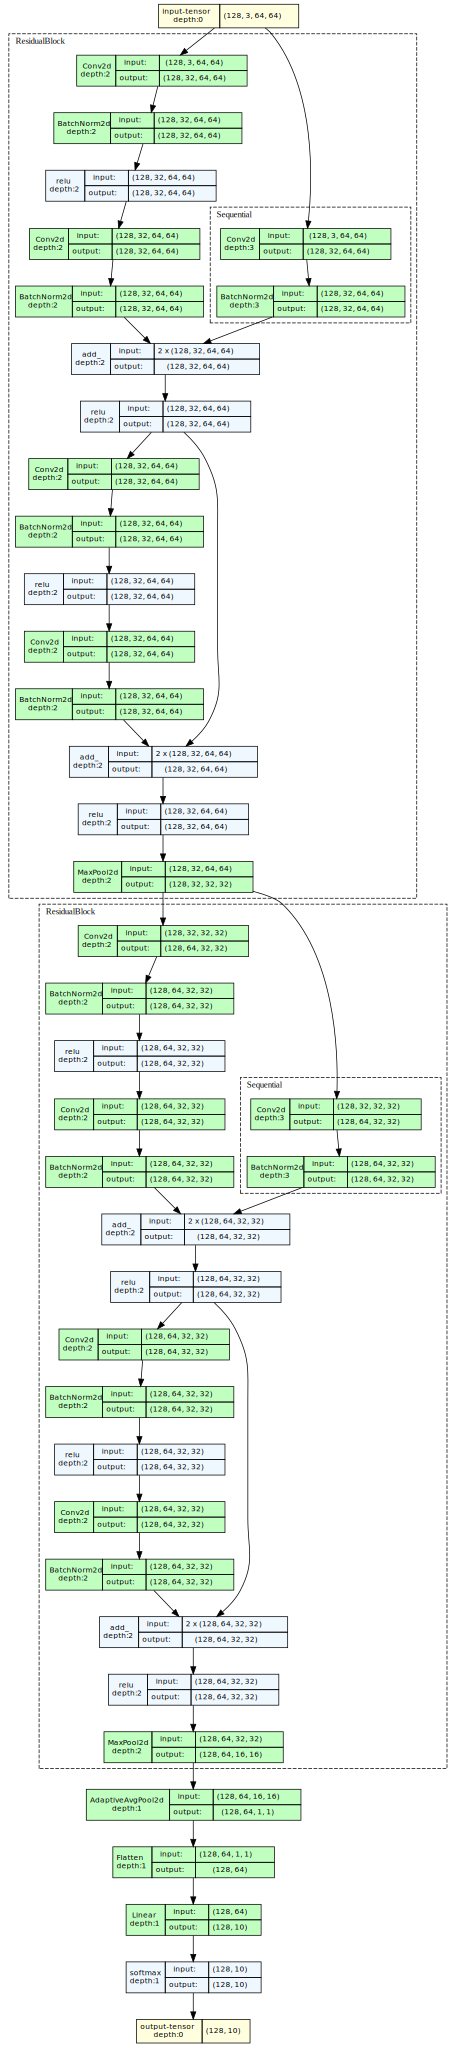

In [34]:
# Create and display the ResNet model
resnet_model = ResNetModel(input_shape, output_shape, filters, kernel_size, stack, blocks).to(device)
summary(resnet_model, input_size=input_shape)
model_graph = draw_graph(resnet_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True)
model_graph.visual_graph

## 🛠️ **Depthwise Separable Convolutions (MobileNetV1, 2017)**

<img src="https://miro.medium.com/v2/resize:fit:1400/1*yG6z6ESzsRW-9q5F_neOsg.png" width="800"/>

---
**Key Features and Achievements**

* Drastically reduced computational cost and model size
* Enabled efficient deep learning on mobile and embedded devices
* Introduced depthwise separable convolutions as core building block

**Key building block**

* Depthwise convolution: applies single filter per input channel
* Pointwise convolution (1x1): combines outputs from depthwise layer
* Reduces computation by factor of 8-9x compared to standard convolutions
* Each conv followed by BatchNorm and ReLU

**Impact**

* Pioneered efficient neural network design for resource-constrained devices
* Established depthwise separable convolutions as standard for mobile architectures
* Inspired subsequent mobile-optimized architectures (MobileNetV2, V3)

**📜 Paper:** ["MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", Howard et al.](https://arxiv.org/pdf/1704.04861)

In [35]:
class MobileNetBlock(nn.Module):
    """
    MobileNet Block: Stack of Depthwise Separable Convs + Final Pooling.
    """
    def __init__(self, in_channels, filters, kernel_size=3, stack=2):
        """Initialises the MobileNetBlock.

        Args:
            in_channels (int): Number of input channels.
            filters (int): Number of output filters.
            kernel_size (int, optional): Size of the convolutional kernel. Defaults to 3.
            stack (int, optional): Number of Depthwise Separable units to stack. Defaults to 2.
        """
        super().__init__()

        self.layers = nn.ModuleList()
        current_in = in_channels

        for s in range(stack):
            # Depthwise convolution: applies a single filter per input channel.
            dw = nn.Conv2d(current_in, current_in, kernel_size, padding='same', groups=current_in, bias=False)
            bn1 = nn.BatchNorm2d(current_in)
            # Pointwise convolution (1x1): combines outputs from depthwise layer.
            pw = nn.Conv2d(current_in, filters, 1, bias=False)
            bn2 = nn.BatchNorm2d(filters)

            self.layers.append(nn.Sequential(
                dw, bn1, nn.ReLU(),
                pw, bn2, nn.ReLU()
            ))
            current_in = filters

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after block processing.
        """
        for layer in self.layers:
            x = layer(x)
        return self.pool(x)

class MobileNetV1Model(nn.Module):
    """Complete CNN model using multiple MobileNetBlocks and Global Average Pooling.

    Suitable for efficient classification tasks.
    """
    def __init__(self, input_shape, output_shape, filters=32, kernel_size=3, stack=2, blocks=3):
        """Initialises the MobileNetV1Model.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 32.
            kernel_size (int, optional): Kernel size for convolutional layers. Defaults to 3.
            stack (int, optional): Number of Depthwise Separable units per block. Defaults to 2.
            blocks (int, optional): Number of `MobileNetBlock` instances to stack. Defaults to 3.
        """
        super().__init__()

        self.blocks_list = nn.ModuleList()
        current_channels = input_shape[0]
        current_filters = filters

        # Initial Conv to expand channels usually helps MobileNet
        self.init_conv = nn.Sequential(
            nn.Conv2d(current_channels, filters, 3, padding='same', bias=False),
            nn.BatchNorm2d(filters),
            nn.ReLU()
        )
        current_channels = filters

        for b in range(blocks):
            self.blocks_list.append(
                MobileNetBlock(current_channels, current_filters, kernel_size, stack)
            )
            current_channels = current_filters
            current_filters *= 2

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(current_channels, output_shape)

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        x = self.init_conv(x)
        for block in self.blocks_list:
            x = block(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense(x)
        return F.softmax(x, dim=1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 32, 64, 64]           1,024
       BatchNorm2d-8           [-1, 32, 64, 64]              64
              ReLU-9           [-1, 32, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]             288
      BatchNorm2d-11           [-1, 32, 64, 64]              64
             ReLU-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 32, 64, 64]           1,024
      BatchNorm2d-14           [-1, 32,

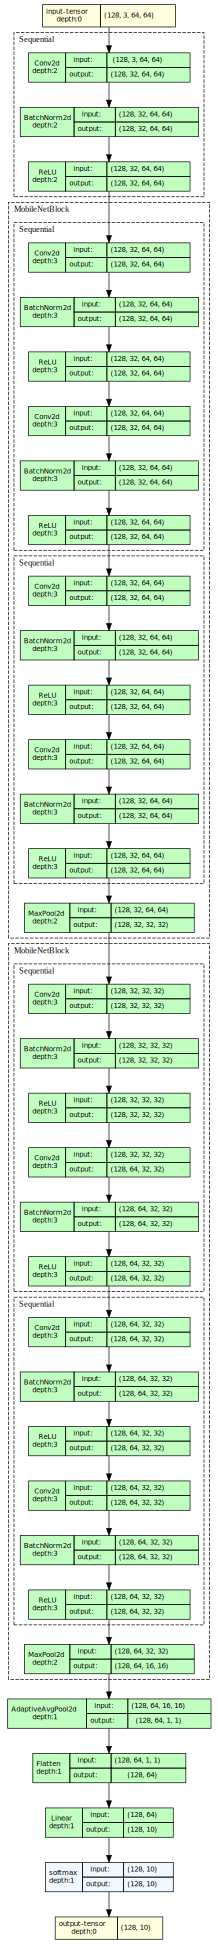

In [36]:
# Create and display the MobileNetV1 model
mobilenet_model = MobileNetV1Model(input_shape, output_shape, filters, kernel_size, stack, blocks).to(device)
summary(mobilenet_model, input_size=input_shape)
model_graph = draw_graph(mobilenet_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=5)
model_graph.visual_graph

## 🛠️ **Wide Residual Networks (WideResNet, 2016)**

<img src="https://pytorch.org/wp-content/uploads/2025/01/wide_resnet-1.png" width="800"/>

---
**Key Features and Achievements**

* Demonstrated that wider networks can be more effective than deeper ones
* Improved performance with fewer layers through increased channel width
* Reduced training time while maintaining or improving accuracy

**Key building block:**

* Widened residual blocks with widening factor k (typically k=2-12)
* Two conv layers with BN-ReLU-Conv ordering (pre-activation)
* Dropout between convolutions for regularization

**Impact:**

* Challenged the "deeper is better" paradigm
* Showed width as important dimension for network capacity
* Influenced efficient network design strategies
* Demonstrated effectiveness of proper regularization in wide networks

**📜 Paper:** ["Wide Residual Networks", Zagoruyko and Komodakis](https://arxiv.org/pdf/1605.07146)

In [37]:
class WideResBlock(nn.Module):
    """
    Wide Residual Block: Pre-activation BN->ReLU->Conv.
    Uses 'widening_factor' to increase internal filter count.
    """
    def __init__(self, in_channels, filters, kernel_size=3, stack=2, k=2, dropout=0.3):
        super().__init__()

        self.units = nn.ModuleList()
        current_in = in_channels
        wide_filters = filters * k

        for s in range(stack):
            unit = nn.ModuleDict()

            # Unit 1: BN -> ReLU -> Conv
            unit['bn1'] = nn.BatchNorm2d(current_in)
            unit['conv1'] = nn.Conv2d(current_in, wide_filters, kernel_size, padding='same', bias=False)

            unit['dropout'] = nn.Dropout(dropout)

            # Unit 2: BN -> ReLU -> Conv
            unit['bn2'] = nn.BatchNorm2d(wide_filters)
            unit['conv2'] = nn.Conv2d(wide_filters, filters, kernel_size, padding='same', bias=False)

            # Projection
            if current_in != filters:
                unit['proj'] = nn.Conv2d(current_in, filters, 1, padding='same', bias=False)

            self.units.append(unit)
            current_in = filters # Output of block matches 'filters' for outer loop structure.

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        for unit in self.units:
            residual = x

            out = unit['bn1'](x)
            out = F.relu(out)
            out = unit['conv1'](out)

            out = unit['dropout'](out)

            out = unit['bn2'](out)
            out = F.relu(out)
            out = unit['conv2'](out)

            if 'proj' in unit:
                residual = unit['proj'](residual)

            x = out + residual

        return self.pool(x)

class WideResNetModel(nn.Module):
    """Complete CNN model using multiple WideResBlocks and Global Average Pooling.

    Suitable for classification tasks with increased width.
    """
    def __init__(self, input_shape, output_shape, filters=32, kernel_size=3, stack=2, blocks=3, k=2):
        """Initialises the WideResNetModel.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 32.
            kernel_size (int, optional): Kernel size for convolutional layers. Defaults to 3.
            stack (int, optional): Number of residual units per block. Defaults to 2.
            blocks (int, optional): Number of `WideResBlock` instances to stack. Defaults to 3.
            k (int, optional): Widening factor for the internal layers of `WideResBlock`. Defaults to 2.
        """
        super().__init__()

        self.blocks_list = nn.ModuleList()
        # Initial convolutional layer
        self.init_conv = nn.Conv2d(input_shape[0], filters, 3, padding='same', bias=False)

        current_channels = filters
        current_filters = filters

        # Stack WideResBlocks, doubling filters for each.
        for b in range(blocks):
            self.blocks_list.append(
                WideResBlock(current_channels, current_filters, kernel_size, stack, k=k)
            )
            current_channels = current_filters
            current_filters *= 2

        self.gap = nn.AdaptiveAvgPool2d(1) # Global Average Pooling
        self.flatten = nn.Flatten() # Flatten multi-dimensional output to 1D vector
        self.dense = nn.Linear(current_channels, output_shape) # Final fully connected layer

    def forward(self, x):
        """Defines the forward pass.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        x = self.init_conv(x)
        for block in self.blocks_list:
            x = block(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense(x)
        return F.softmax(x, dim=1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
            Conv2d-3           [-1, 64, 64, 64]          18,432
           Dropout-4           [-1, 64, 64, 64]               0
       BatchNorm2d-5           [-1, 64, 64, 64]             128
            Conv2d-6           [-1, 32, 64, 64]          18,432
       BatchNorm2d-7           [-1, 32, 64, 64]              64
            Conv2d-8           [-1, 64, 64, 64]          18,432
           Dropout-9           [-1, 64, 64, 64]               0
      BatchNorm2d-10           [-1, 64, 64, 64]             128
           Conv2d-11           [-1, 32, 64, 64]          18,432
        MaxPool2d-12           [-1, 32, 32, 32]               0
     WideResBlock-13           [-1, 32, 32, 32]               0
      BatchNorm2d-14           [-1, 32,

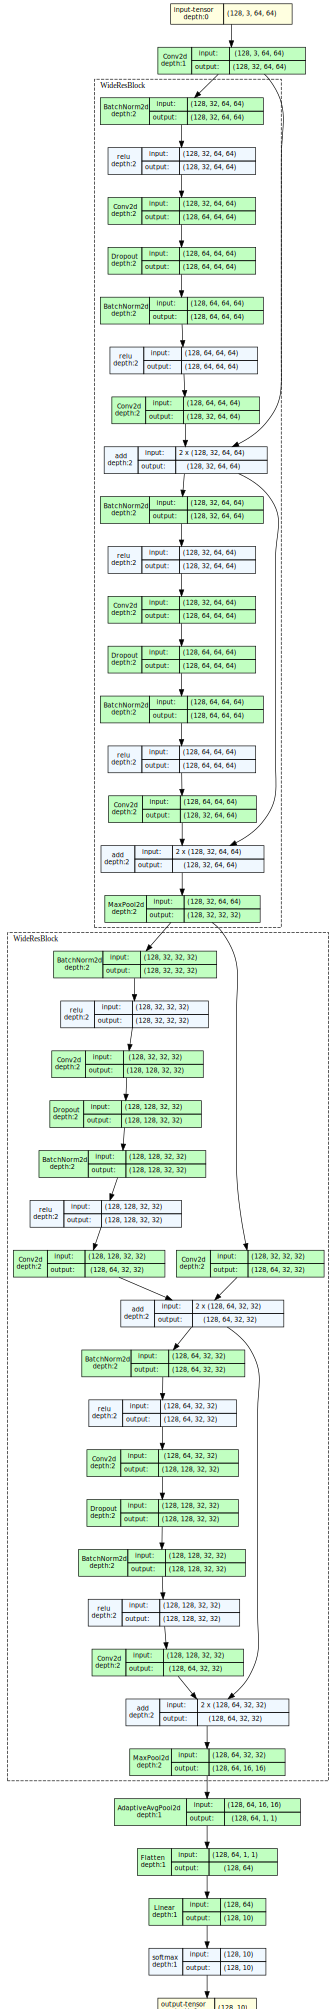

In [38]:
# Create and display the WideResNet model
wideresnet_model = WideResNetModel(input_shape, output_shape, filters, kernel_size, stack, blocks).to(device)
summary(wideresnet_model, input_size=input_shape)
model_graph = draw_graph(wideresnet_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=5)
model_graph.visual_graph

## 🛠️ **Aggregated Residual Transformations (ResNeXt, 2017)**

<img src="https://lh4.googleusercontent.com/0KY-EvKoVReJesGJbgfekaYuNZPVXdyxjBMfwKSgUsU5w9Ajp9j-cTdGjD7rubacjiJj9JLsp64DoC-Cdp5qyNQV-PRIR7EnNZ1jKm3UqsGqro3wNEAOtDphGgERgPz8g7OpSau1" width="800"/>

---
**Key Features and Achievements**

* Introduced cardinality (number of paths) as new dimension for network design
* Achieved better accuracy than ResNet with similar complexity
* Won 2nd place in ILSVRC 2016 classification task

**Key building block**

* Multiple parallel pathways (cardinality) with same topology
* Split-transform-merge strategy: split input, apply transformations, aggregate
* Grouped convolutions for efficient implementation

**Impact**

* Established cardinality as important architectural dimension alongside depth and width
* Showed that increasing cardinality is more effective than going deeper or wider
* Influenced efficient multi-path architectures
* Demonstrated grouped convolutions as powerful design pattern

**📜 Paper:** ["Aggregated Residual Transformations for Deep Neural Networks", Xie et al.](https://arxiv.org/pdf/1611.05431)

In [39]:
class ResNeXtBlock(nn.Module):
    """
    ResNeXt Block with Cardinality (groups).
    This block introduces the concept of 'cardinality', allowing for multiple parallel paths.
    """
    def __init__(self, in_channels, filters, kernel_size=3, stack=2, cardinality=8):
        """Initialises the ResNeXtBlock.

        Args:
            in_channels (int): Number of input channels.
            filters (int): Number of output filters for the block.
            kernel_size (int, optional): Size of the convolutional kernel. Defaults to 3.
            stack (int, optional): Number of residual units to stack within the block. Defaults to 2.
            cardinality (int, optional): The number of independent paths (groups) in the grouped convolution. Defaults to 8.
        """
        super().__init__()

        self.units = nn.ModuleList()
        current_in = in_channels

        # Calculate the width of the bottleneck layers.
        # This width ('d') is typically chosen to be divisible by the cardinality.
        d = max(cardinality, filters // 2)

        for s in range(stack):
            unit = nn.ModuleDict()

            # First 1x1 Convolution: Reduces dimensions before the grouped convolution.
            unit['conv1'] = nn.Conv2d(current_in, d, 1, bias=False)
            unit['bn1'] = nn.BatchNorm2d(d)

            # Grouped 3x3 Convolution: The core of ResNeXt, applying 'cardinality' parallel transformations.
            unit['conv2'] = nn.Conv2d(d, d, kernel_size, padding='same', groups=cardinality, bias=False)
            unit['bn2'] = nn.BatchNorm2d(d)

            # Second 1x1 Convolution: Expands dimensions back to 'filters'.
            unit['conv3'] = nn.Conv2d(d, filters, 1, bias=False)
            unit['bn3'] = nn.BatchNorm2d(filters)

            # Projection for the shortcut connection if input and output channels differ.
            if current_in != filters:
                unit['proj'] = nn.Sequential(
                    nn.Conv2d(current_in, filters, 1, bias=False),
                    nn.BatchNorm2d(filters)
                )

            self.units.append(unit)
            current_in = filters # The output channels become the input for the next unit in the stack.

        self.pool = nn.MaxPool2d(2) # Max pooling at the end of the block for spatial downsampling.

    def forward(self, x):
        """Defines the forward pass of the ResNeXtBlock.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after block processing.
        """
        for unit in self.units:
            residual = x

            # Bottleneck convolution with BN and ReLU
            out = F.relu(unit['bn1'](unit['conv1'](x)))
            # Grouped convolution with BN and ReLU
            out = F.relu(unit['bn2'](unit['conv2'](out)))
            # Expansion convolution with BN
            out = unit['bn3'](unit['conv3'](out))

            # Apply projection to residual if needed
            if 'proj' in unit:
                residual = unit['proj'](residual)

            # Element-wise addition of residual and block output, followed by final ReLU
            x = F.relu(out + residual)

        return self.pool(x)

class ResNeXtModel(nn.Module):
    """Complete CNN model using multiple ResNeXtBlocks and Global Average Pooling.

    This model integrates the ResNeXt architecture for classification tasks.
    """
    def __init__(self, input_shape, output_shape, filters=32, kernel_size=3, stack=2, blocks=3, cardinality=8):
        """Initialises the ResNeXtModel.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 32.
            kernel_size (int, optional): Kernel size for convolutional layers. Defaults to 3.
            stack (int, optional): Number of residual units per block. Defaults to 2.
            blocks (int, optional): Number of `ResNeXtBlock` instances to stack. Defaults to 3.
            cardinality (int, optional): The number of independent paths in the grouped convolution. Defaults to 8.
        """
        super().__init__()

        self.blocks_list = nn.ModuleList()

        # Initial convolutional layer to process input, ensuring channels meet cardinality requirement.
        start_filters = max(filters, cardinality)
        self.init_conv = nn.Sequential(
            nn.Conv2d(input_shape[0], start_filters, 3, padding='same', bias=False),
            nn.BatchNorm2d(start_filters),
            nn.ReLU()
        )

        current_channels = start_filters
        current_filters = start_filters

        # Stack multiple ResNeXtBlocks, typically doubling filters for each subsequent block.
        for b in range(blocks):
            self.blocks_list.append(
                ResNeXtBlock(current_channels, current_filters, kernel_size, stack, cardinality)
            )
            current_channels = current_filters
            current_filters *= 2

        self.gap = nn.AdaptiveAvgPool2d(1) # Global Average Pooling to reduce spatial dimensions to 1x1.
        self.flatten = nn.Flatten() # Flattens the pooled output into a 1D vector.
        self.dense = nn.Linear(current_channels, output_shape) # Final fully connected layer for classification.

    def forward(self, x):
        """Defines the forward pass of the ResNeXtModel.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        x = self.init_conv(x)
        for block in self.blocks_list:
            x = block(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense(x)
        return F.softmax(x, dim=1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]             512
       BatchNorm2d-5           [-1, 16, 64, 64]              32
            Conv2d-6           [-1, 16, 64, 64]             288
       BatchNorm2d-7           [-1, 16, 64, 64]              32
            Conv2d-8           [-1, 32, 64, 64]             512
       BatchNorm2d-9           [-1, 32, 64, 64]              64
           Conv2d-10           [-1, 16, 64, 64]             512
      BatchNorm2d-11           [-1, 16, 64, 64]              32
           Conv2d-12           [-1, 16, 64, 64]             288
      BatchNorm2d-13           [-1, 16, 64, 64]              32
           Conv2d-14           [-1, 32,

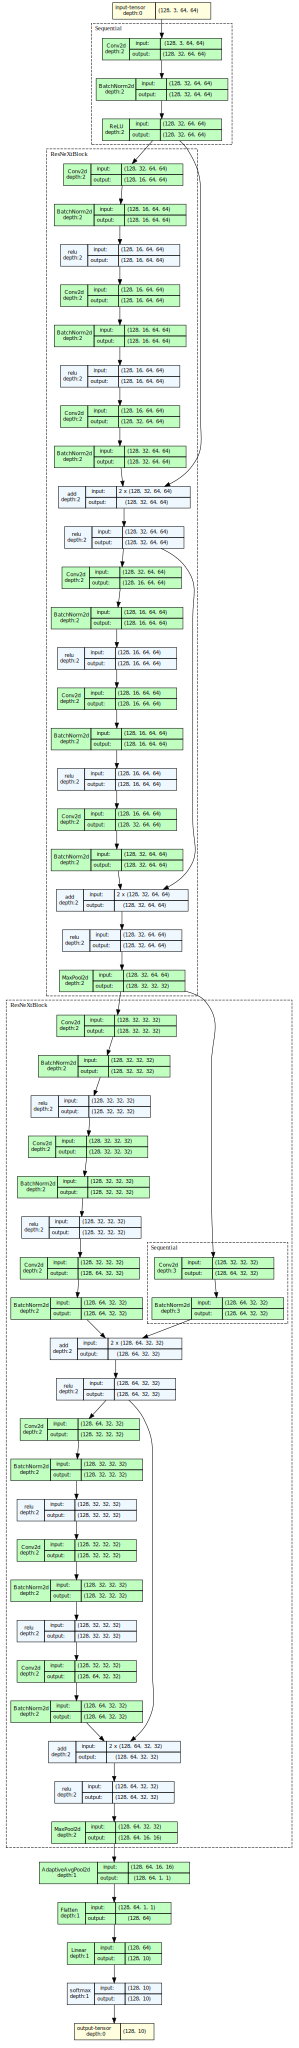

In [40]:
# Create and display the ResNeXt model
resnext_model = ResNeXtModel(input_shape, output_shape, filters, kernel_size, stack, blocks).to(device)
summary(resnext_model, input_size=input_shape)
model_graph = draw_graph(resnext_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=5)
model_graph.visual_graph

## 🛠️ **Dense Connections (DenseNet, 2017)**

<img src="https://miro.medium.com/v2/resize:fit:1400/1*9ysRPSExk0KvXR0AhNnlAA.gif" width="800"/>

---
**Key Features and Achievements**

* Revolutionary dense connectivity pattern: each layer connected to all previous layers
* Achieved state-of-the-art results with fewer parameters
* Won best paper award at CVPR 2017

**Key building block:**

* Dense connectivity: each layer receives feature maps from all preceding layers
* Feature concatenation instead of summation
* Growth rate k: each layer adds k feature maps
* Composite function: BN-ReLU-Conv

**Impact:**

* Maximized information flow through direct connections
* Alleviated vanishing gradient problem through short paths
* Encouraged feature reuse, reducing parameter count
* Demonstrated effectiveness of dense connectivity patterns

**📜 Paper:** ["Densely Connected Convolutional Networks", Huang et al.](https://arxiv.org/pdf/1608.06993)

In [41]:
class DenseNetBlock(nn.Module):
    """
    DenseBlock + Transition (Pooling + Channel Resizing).
    In this custom implementation, the Transition layer forces the output channels
    to match the 'next_filters' expected by the outer loop (Double Filters).
    """
    def __init__(self, in_channels, out_channels_target, growth_rate=12, kernel_size=3, stack=2):
        super().__init__()

        self.layers = nn.ModuleList()
        current_in = in_channels

        # Dense Sequence: Each layer concatenates its output to the block's input.
        for s in range(stack):
            self.layers.append(nn.Sequential(
                nn.BatchNorm2d(current_in),
                nn.ReLU(),
                nn.Conv2d(current_in, growth_rate, kernel_size, padding='same', bias=False)
            ))
            current_in += growth_rate # The number of channels grows with each layer.

        # Transition Layer: 1x1 Conv to set channels -> Pool
        # Reduces feature map dimensions and prepares for the next DenseNetBlock.
        self.transition = nn.Sequential(
            nn.BatchNorm2d(current_in),
            nn.ReLU(),
            nn.Conv2d(current_in, out_channels_target, 1, bias=False),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        for layer in self.layers:
            out = layer(x)
            x = torch.cat([x, out], dim=1) # Concatenate output with previous features.
        return self.transition(x)

class DenseNetModel(nn.Module):
    """Complete CNN model using multiple DenseNetBlocks and Global Average Pooling.

    This model integrates the DenseNet architecture for classification tasks.
    """
    def __init__(self, input_shape, output_shape, filters=32, kernel_size=3, stack=4, blocks=3):
        """Initialises the DenseNetModel.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 32.
            kernel_size (int, optional): Kernel size for convolutional layers. Defaults to 3.
            stack (int, optional): Number of layers per dense block. Defaults to 4.
            blocks (int, optional): Number of `DenseNetBlock` instances to stack. Defaults to 3.
        """
        super().__init__()

        self.blocks_list = nn.ModuleList()
        current_channels = input_shape[0]
        current_filters = filters

        # Initial Conv layer.
        self.init_conv = nn.Conv2d(current_channels, filters, 3, padding='same', bias=False)
        current_channels = filters

        # Stack DenseNetBlocks, where each transition layer aims to halve the feature maps.
        for b in range(blocks):
            # Target is the filter count for the NEXT block input, effectively doubling filters.
            target_filters = current_filters * 2

            self.blocks_list.append(
                DenseNetBlock(current_channels, target_filters, growth_rate=filters//2, kernel_size=kernel_size, stack=stack)
            )
            current_channels = target_filters # The transition layer outputs this number of channels.
            current_filters *= 2 # Double filters for the next block.

        self.gap = nn.AdaptiveAvgPool2d(1) # Global Average Pooling to reduce spatial dimensions to 1x1.
        self.flatten = nn.Flatten() # Flattens the pooled output into a 1D vector.
        self.dense = nn.Linear(current_channels, output_shape) # Final fully connected layer for classification.

    def forward(self, x):
        """Defines the forward pass of the DenseNetModel.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        x = self.init_conv(x)
        for block in self.blocks_list:
            x = block(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense(x)
        return F.softmax(x, dim=1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           4,608
       BatchNorm2d-5           [-1, 48, 64, 64]              96
              ReLU-6           [-1, 48, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]           6,912
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]           4,096
        MaxPool2d-11           [-1, 64, 32, 32]               0
    DenseNetBlock-12           [-1, 64, 32, 32]               0
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

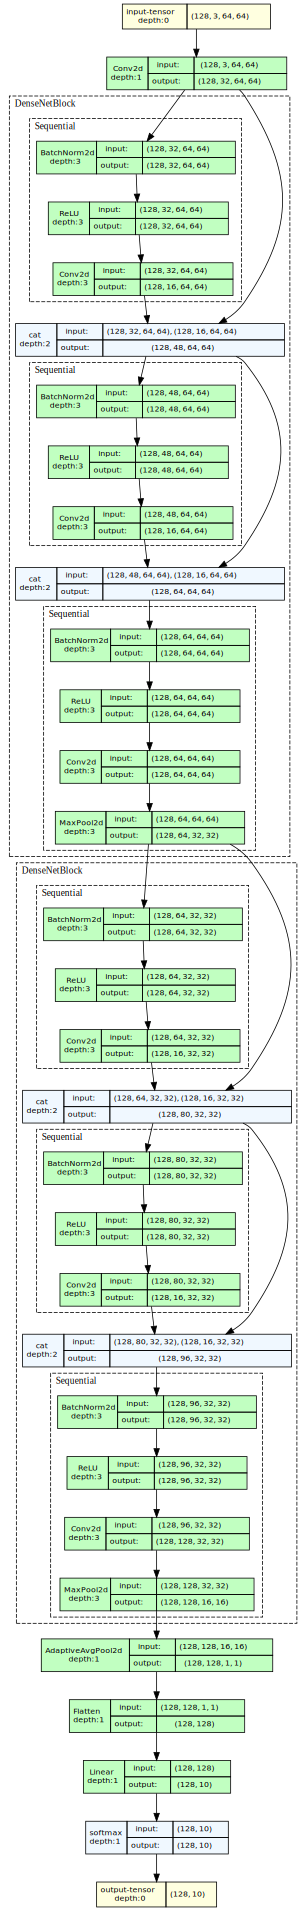

In [42]:
# Create and display the DenseNet model
densenet_model = DenseNetModel(input_shape, output_shape, filters, kernel_size, stack, blocks).to(device)
summary(densenet_model, input_size=input_shape)
model_graph = draw_graph(densenet_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=5)
model_graph.visual_graph

## 🛠️ **Compound Scaling (EfficientNet, 2019)**

<img src="https://storage.googleapis.com/gweb-research2023-media/original_images/9ad0a8c7dd04c2b427a537c6229d39f9-image4.png" width="800"/>

---
**Key Features and Achievements**

* Introduced compound scaling method: jointly scale depth, width, and resolution
* Achieved state-of-the-art accuracy with 8.4x fewer parameters than best existing CNN
* Used Neural Architecture Search (NAS) to find optimal baseline network

**Key building block:**

* Mobile Inverted Bottleneck Conv (MBConv) with squeeze-and-excitation
* Compound scaling with fixed ratios: depth × width² × resolution² ≈ 2
* Swish activation function for better accuracy

**Impact:**

* Demonstrated importance of balanced scaling across all dimensions
* Established new paradigm for scaling neural networks efficiently
* Showed that careful architecture design and scaling can dramatically improve efficiency
* Set new standard for accuracy-efficiency trade-offs

**📜 Paper:** ["EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks", Tan and Le](https://arxiv.org/pdf/1905.11946)

In [43]:
class MBConvBlock(nn.Module):
    """
    MBConv: Expand (1x1) -> Depthwise (3x3) -> SE -> Project (1x1).
    Followed by MaxPool at the end of the stack sequence.
    """
    def __init__(self, in_channels, filters, kernel_size=3, stack=2, expansion=4):
        super().__init__()

        self.units = nn.ModuleList()
        current_in = in_channels

        for s in range(stack):
            unit = nn.ModuleList()
            expanded = current_in * expansion

            # Expansion Phase (1x1 convolution to expand channels)
            if expansion != 1:
                unit.append(nn.Sequential(
                    nn.Conv2d(current_in, expanded, 1, bias=False),
                    nn.BatchNorm2d(expanded),
                    nn.SiLU() # Swish activation
                ))

            # Depthwise Convolution (applies a single filter per input channel)
            unit.append(nn.Sequential(
                nn.Conv2d(expanded, expanded, kernel_size, padding='same', groups=expanded, bias=False),
                nn.BatchNorm2d(expanded),
                nn.SiLU()
            ))

            # Squeeze and Excitation block
            se_in = expanded
            se_reduced = max(1, int(se_in * 0.25))
            unit.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(se_in, se_reduced, 1),
                nn.SiLU(),
                nn.Conv2d(se_reduced, se_in, 1),
                nn.Sigmoid()
            ))

            # Output Projection Phase (1x1 convolution to project channels back)
            unit.append(nn.Sequential(
                nn.Conv2d(expanded, filters, 1, bias=False),
                nn.BatchNorm2d(filters)
            ))

            self.units.append(unit)

            # Update current_in for the next stacked unit
            current_in = filters

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        for unit in self.units:
            residual = x

            # Expand (if expansion factor is not 1)
            out = unit[0](x) if len(unit) == 4 else x
            # Depthwise (index shifts if expansion is skipped)
            dw_idx = 1 if len(unit) == 4 else 0
            out = unit[dw_idx](out)

            # Squeeze and Excitation
            se_w = unit[dw_idx+1](out)
            out = out * se_w

            # Project
            out = unit[dw_idx+2](out)

            # Add residual connection if input and output dimensions match
            if x.shape == out.shape:
                out += x

            x = out

        return self.pool(x)

class EfficientNetModel(nn.Module):
    """Complete CNN model using multiple MBConvBlocks and Global Average Pooling.

    This model integrates the EfficientNet architecture for classification tasks.
    """
    def __init__(self, input_shape, output_shape, filters=32, kernel_size=3, stack=2, blocks=3):
        """Initialises the EfficientNetModel.

        Args:
            input_shape (tuple): Shape of the input images (C, H, W).
            output_shape (int): Number of output classes.
            filters (int, optional): Initial number of filters for the first block. Defaults to 32.
            kernel_size (int, optional): Kernel size for convolutional layers. Defaults to 3.
            stack (int, optional): Number of MBConv units per block. Defaults to 2.
            blocks (int, optional): Number of `MBConvBlock` instances to stack. Defaults to 3.
        """
        super().__init__()

        self.blocks_list = nn.ModuleList()
        current_channels = input_shape[0]
        current_filters = filters

        # Initial Convolutional layer
        self.init_conv = nn.Sequential(
            nn.Conv2d(current_channels, filters, 3, padding='same', bias=False),
            nn.BatchNorm2d(filters),
            nn.SiLU()
        )
        current_channels = filters

        # Stack multiple MBConvBlocks, typically doubling filters for each subsequent block
        for b in range(blocks):
            self.blocks_list.append(
                MBConvBlock(current_channels, current_filters, kernel_size, stack)
            )
            current_channels = current_filters
            current_filters *= 2

        self.gap = nn.AdaptiveAvgPool2d(1) # Global Average Pooling
        self.flatten = nn.Flatten() # Flatten multi-dimensional output
        self.dense = nn.Linear(current_channels, output_shape) # Final fully connected layer

    def forward(self, x):
        """Defines the forward pass of the EfficientNetModel.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities after Softmax activation.
        """
        x = self.init_conv(x)
        for block in self.blocks_list:
            x = block(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dense(x)
        return F.softmax(x, dim=1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]           4,096
       BatchNorm2d-5          [-1, 128, 64, 64]             256
              SiLU-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]           1,152
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              SiLU-9          [-1, 128, 64, 64]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]           4,128
             SiLU-12             [-1, 32, 1, 1]               0
           Conv2d-13            [-1, 128, 1, 1]           4,224
          Sigmoid-14            [-1, 12

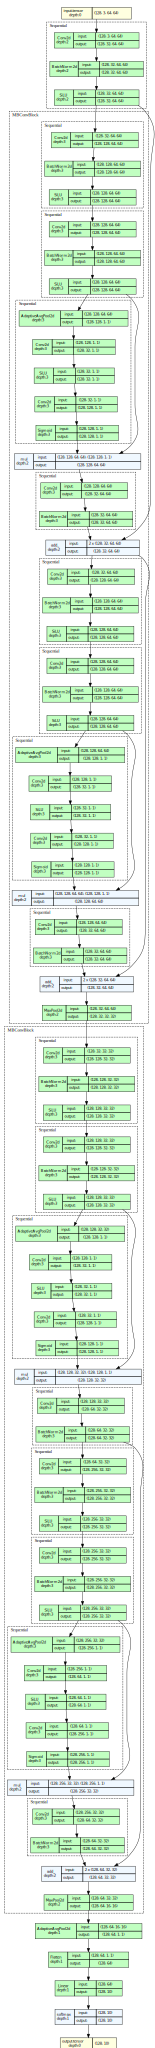

In [44]:
# Create and display the EfficientNetV1 model
efficientnet_model = EfficientNetModel(input_shape, output_shape, filters, kernel_size, stack, blocks).to(device)
summary(efficientnet_model, input_size=input_shape)
model_graph = draw_graph(efficientnet_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=5)
model_graph.visual_graph

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

##### Connect with us:
- <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="14"> **LinkedIn:**  [AIRLab Polimi](https://www.linkedin.com/company/airlab-polimi/)
- <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="14"> **Instagram:** [airlab_polimi](https://www.instagram.com/airlab_polimi/)

##### Contributors:
- **Eugenio Lomurno**: eugenio.lomurno@polimi.it
- **Alberto Archetti**: alberto.archetti@polimi.it
- **Roberto Basla**: roberto.basla@polimi.it
- **Carlo Sgaravatti**: carlo.sgaravatti@polimi.it

```
   Copyright 2025 Eugenio Lomurno, Alberto Archetti, Roberto Basla, Carlo Sgaravatti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```